<a href="https://colab.research.google.com/github/yorketh/machine-learning/blob/master/amazon_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация тональности отзывов Amazon по 5-бальной шкале

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

EDA

In [4]:
reviews_am = pd.read_json('/content/drive/MyDrive/reviews.json', lines=True, nrows=1000000)

In [5]:
reviews_am

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5,True,"01 7, 2015",A2I6GN7OHB9JKF,B00DVH64HW,{'Size:': ' LCD 2 in 1 Meter'},ktr,works great. just what i needed to see what a...,works great. just what i needed to see what am...,1420588800,NaN,NaN
999996,5,True,"11 14, 2014",A1SF2ZAPHIIKUU,B00DVH64HW,{'Size:': ' LCD 2 in 1 Meter'},KOSMOLENYA,"Really good, just need to be calibrated. I ext...",Five Stars,1415923200,NaN,NaN
999997,5,True,"07 4, 2014",A23BUI9NSDYUTY,B00DVH64HW,{'Size:': ' LCD 2 in 1 Meter'},Dsinned,"Last year, I bought several of these on Ebay, ...",Nice product at a bargain price!!!,1404432000,8,NaN
999998,5,True,"05 20, 2014",A3TIYYLNB9XN5E,B00DVH64HW,{'Size:': ' LCD 2 in 1 Meter'},R. Jones,This is a great product. Well manufactured an...,Digital meter.,1400544000,2,NaN


In [ ]:
reviews_am.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         1000000 non-null  int64 
 1   verified        1000000 non-null  bool  
 2   reviewTime      1000000 non-null  object
 3   reviewerID      1000000 non-null  object
 4   asin            1000000 non-null  object
 5   style           358331 non-null   object
 6   reviewerName    999917 non-null   object
 7   reviewText      999636 non-null   object
 8   summary         999862 non-null   object
 9   unixReviewTime  1000000 non-null  int64 
 10  vote            121947 non-null   object
 11  image           16345 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 84.9+ MB


In [ ]:
reviews_am.describe()

,overall,unixReviewTime
count,1000000.000000,1.000000e+06
mean,4.481006,1.436614e+09
std,1.022228,4.976148e+07
min,1.000000,9.688896e+08
25%,4.000000,1.409011e+09
50%,5.000000,1.440029e+09
75%,5.000000,1.472774e+09
max,5.000000,1.530749e+09


45515 уникальных товаров, 186335 уникальных пользователей

In [ ]:
print(reviews_am.asin.nunique())
print(reviews_am.reviewerID.nunique())

45515
186335


Сильный перекос в сторону максимального рейтинга. Самая частая оценка (5) встречается в 25 раз чаще, чем самая редкая (2)

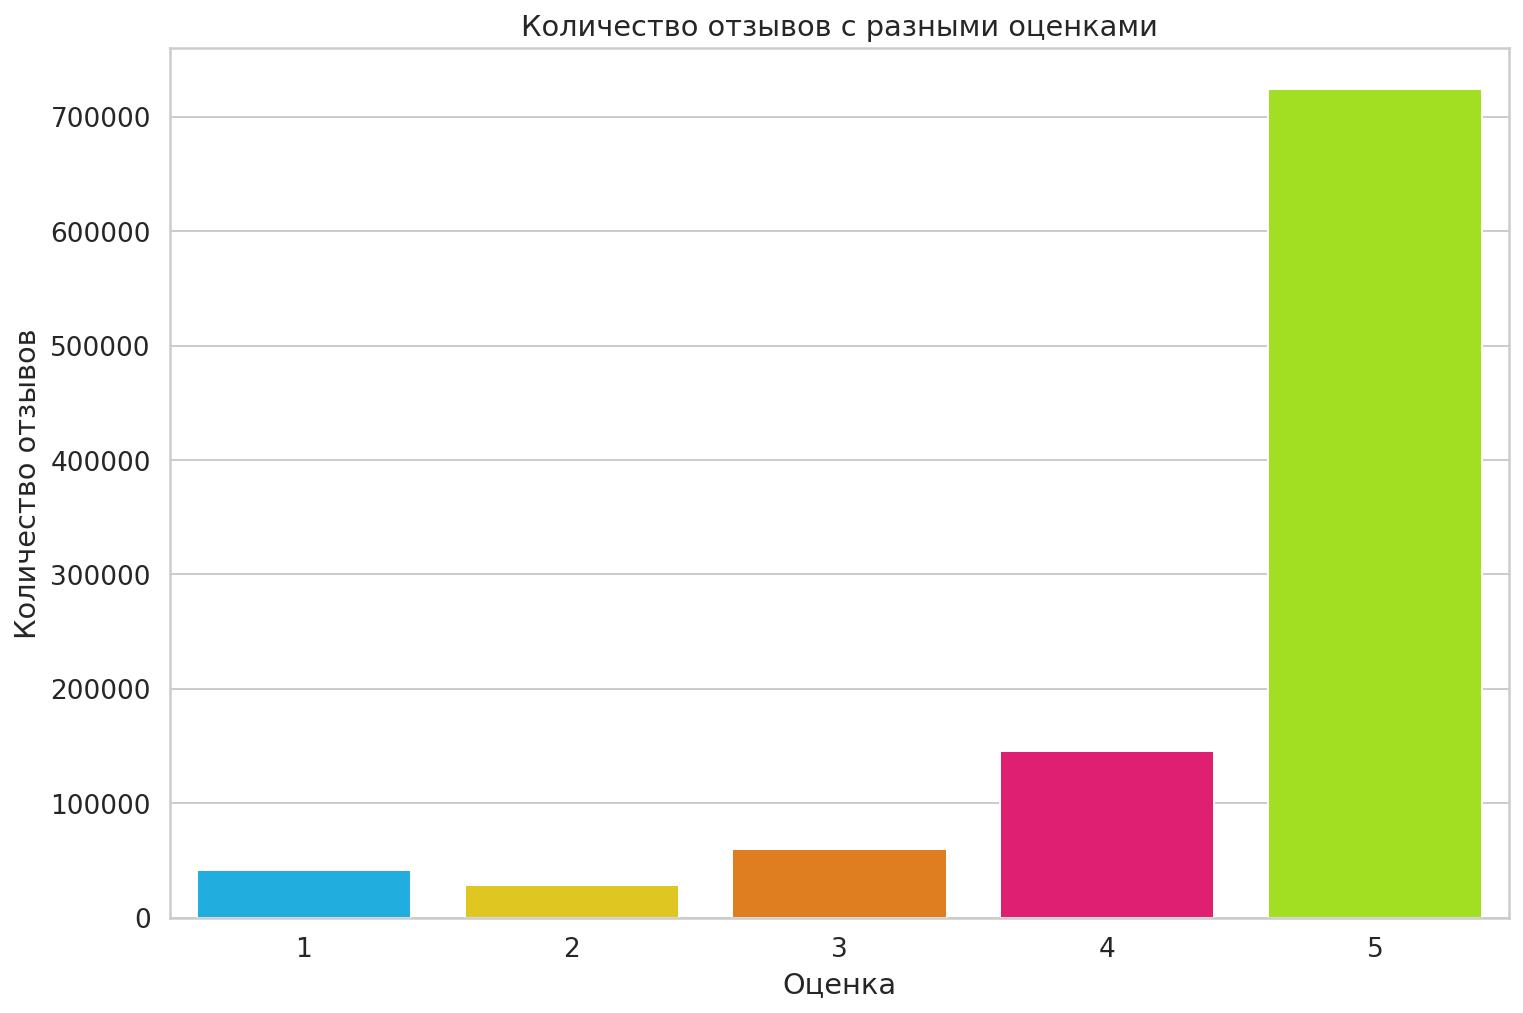

5    724019
4    145661
3     59576
1     41949
2     28795
Name: overall, dtype: int64

In [ ]:
sns.countplot(reviews_am['overall'])
plt.title('Количество отзывов с разными оценками')
plt.xlabel('Оценка')
plt.ylabel('Количество отзывов')
plt.show()

reviews_am['overall'].value_counts()

Отзывы в процентном содержании

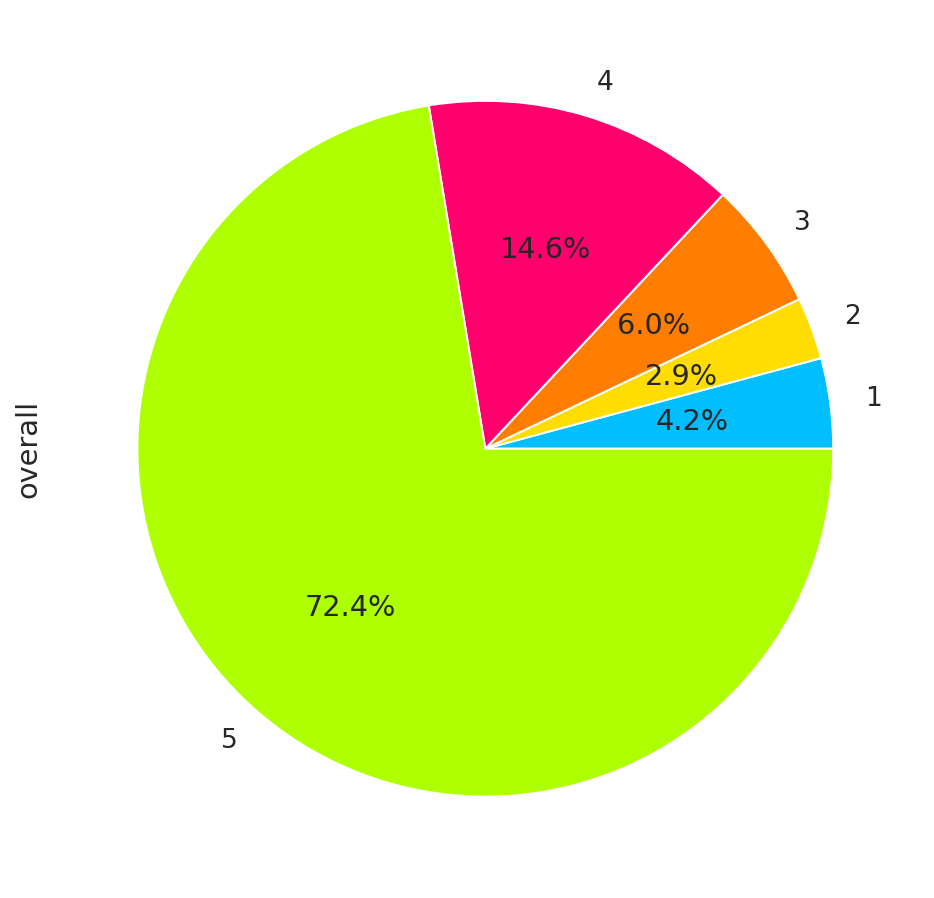

In [ ]:
reviews_am.groupby('overall').overall.count()
reviews_am.groupby('overall').overall.count().plot(kind='pie',autopct='%1.1f%%',)

In [ ]:
users = pd.DataFrame()
users['ID'] = list(reviews_am.groupby('reviewerID').size().sort_values(ascending=False).head(10).index)
users['count'] = list(reviews_am.groupby('reviewerID').size().sort_values(ascending=False).head(10).values)

def get_av(df):
  return reviews_am.loc[reviews_am.reviewerID == df.ID].overall.mean()

users['av_score'] = users.apply(get_av, axis=1)

Топ-10 самых активных обозревателей и их средние оценки

In [ ]:
users

,ID,count,av_score
0,A2QR9IXLMIDL5U,157,3.757962
1,A24FYZZXCMP44U,124,4.887097
2,A2V1J3JT5OOZFO,116,4.482759
3,AJCHGS1GND4OA,115,4.791304
4,A9EL8GNJCW9S8,114,4.938596
5,ANBTTR2QT4C7,112,4.508929
6,A2TM0K7HUH7SLC,109,4.963303
7,A365PBEOWM7EI7,99,4.101010
8,A1AKW788238PWQ,96,4.645833
9,APKBGB3JBWL5X,95,4.852632


In [ ]:
prods = pd.DataFrame()
prods['ID'] = list(reviews_am.groupby('asin').size().sort_values(ascending=False).head(10).index)
prods['count'] = list(reviews_am.groupby('asin').size().sort_values(ascending=False).head(10).values)

def get_av(df):
  return reviews_am.loc[reviews_am.asin == df.ID].overall.mean()

prods['av_score'] = prods.apply(get_av, axis=1)

Топ-10 самых популярных товаров и их средние оценки

In [ ]:
prods

,ID,count,av_score
0,B000W20LKK,5060,4.031621
1,B000CITK8S,3254,4.757837
2,B00480GYSA,2531,4.034769
3,B0010E00T6,1934,4.659772
4,B000M5W25E,1723,4.141613
5,B0015Y5848,1568,4.725765
6,B002OUMVSS,1459,4.571624
7,B001LHVOVK,1390,4.503597
8,B0037V0EW8,1384,4.455925
9,B000GL19WG,1308,4.798165


In [ ]:
reviews_am.loc[(reviews_am.asin==prods.ID.iloc[0])&(reviews_am.image.notna())].image.iloc[0]

['https://images-na.ssl-images-amazon.com/images/I/51H9SsmFpoL._SY88.jpg']

In [ ]:
reviews_am.loc[(reviews_am.asin==prods.ID.iloc[0])&(reviews_am.image.notna())].image.iloc[2]

['https://images-na.ssl-images-amazon.com/images/I/61F68IGEIVL._SY88.jpg']

In [ ]:
reviews_am.loc[(reviews_am.asin==prods.ID.iloc[0])&(reviews_am.image.notna())].image.iloc[3]

['https://images-na.ssl-images-amazon.com/images/I/71+TgZ8H0PL._SY88.jpg']

Очевидно, лампы для автомобильных фар

![](https://images-na.ssl-images-amazon.com/images/I/61F68IGEIVL._SY88.jpg)
![](https://images-na.ssl-images-amazon.com/images/I/71vL8ivWXyL._SY88.jpg)
![](https://images-na.ssl-images-amazon.com/images/I/71+TgZ8H0PL._SY88.jpg)

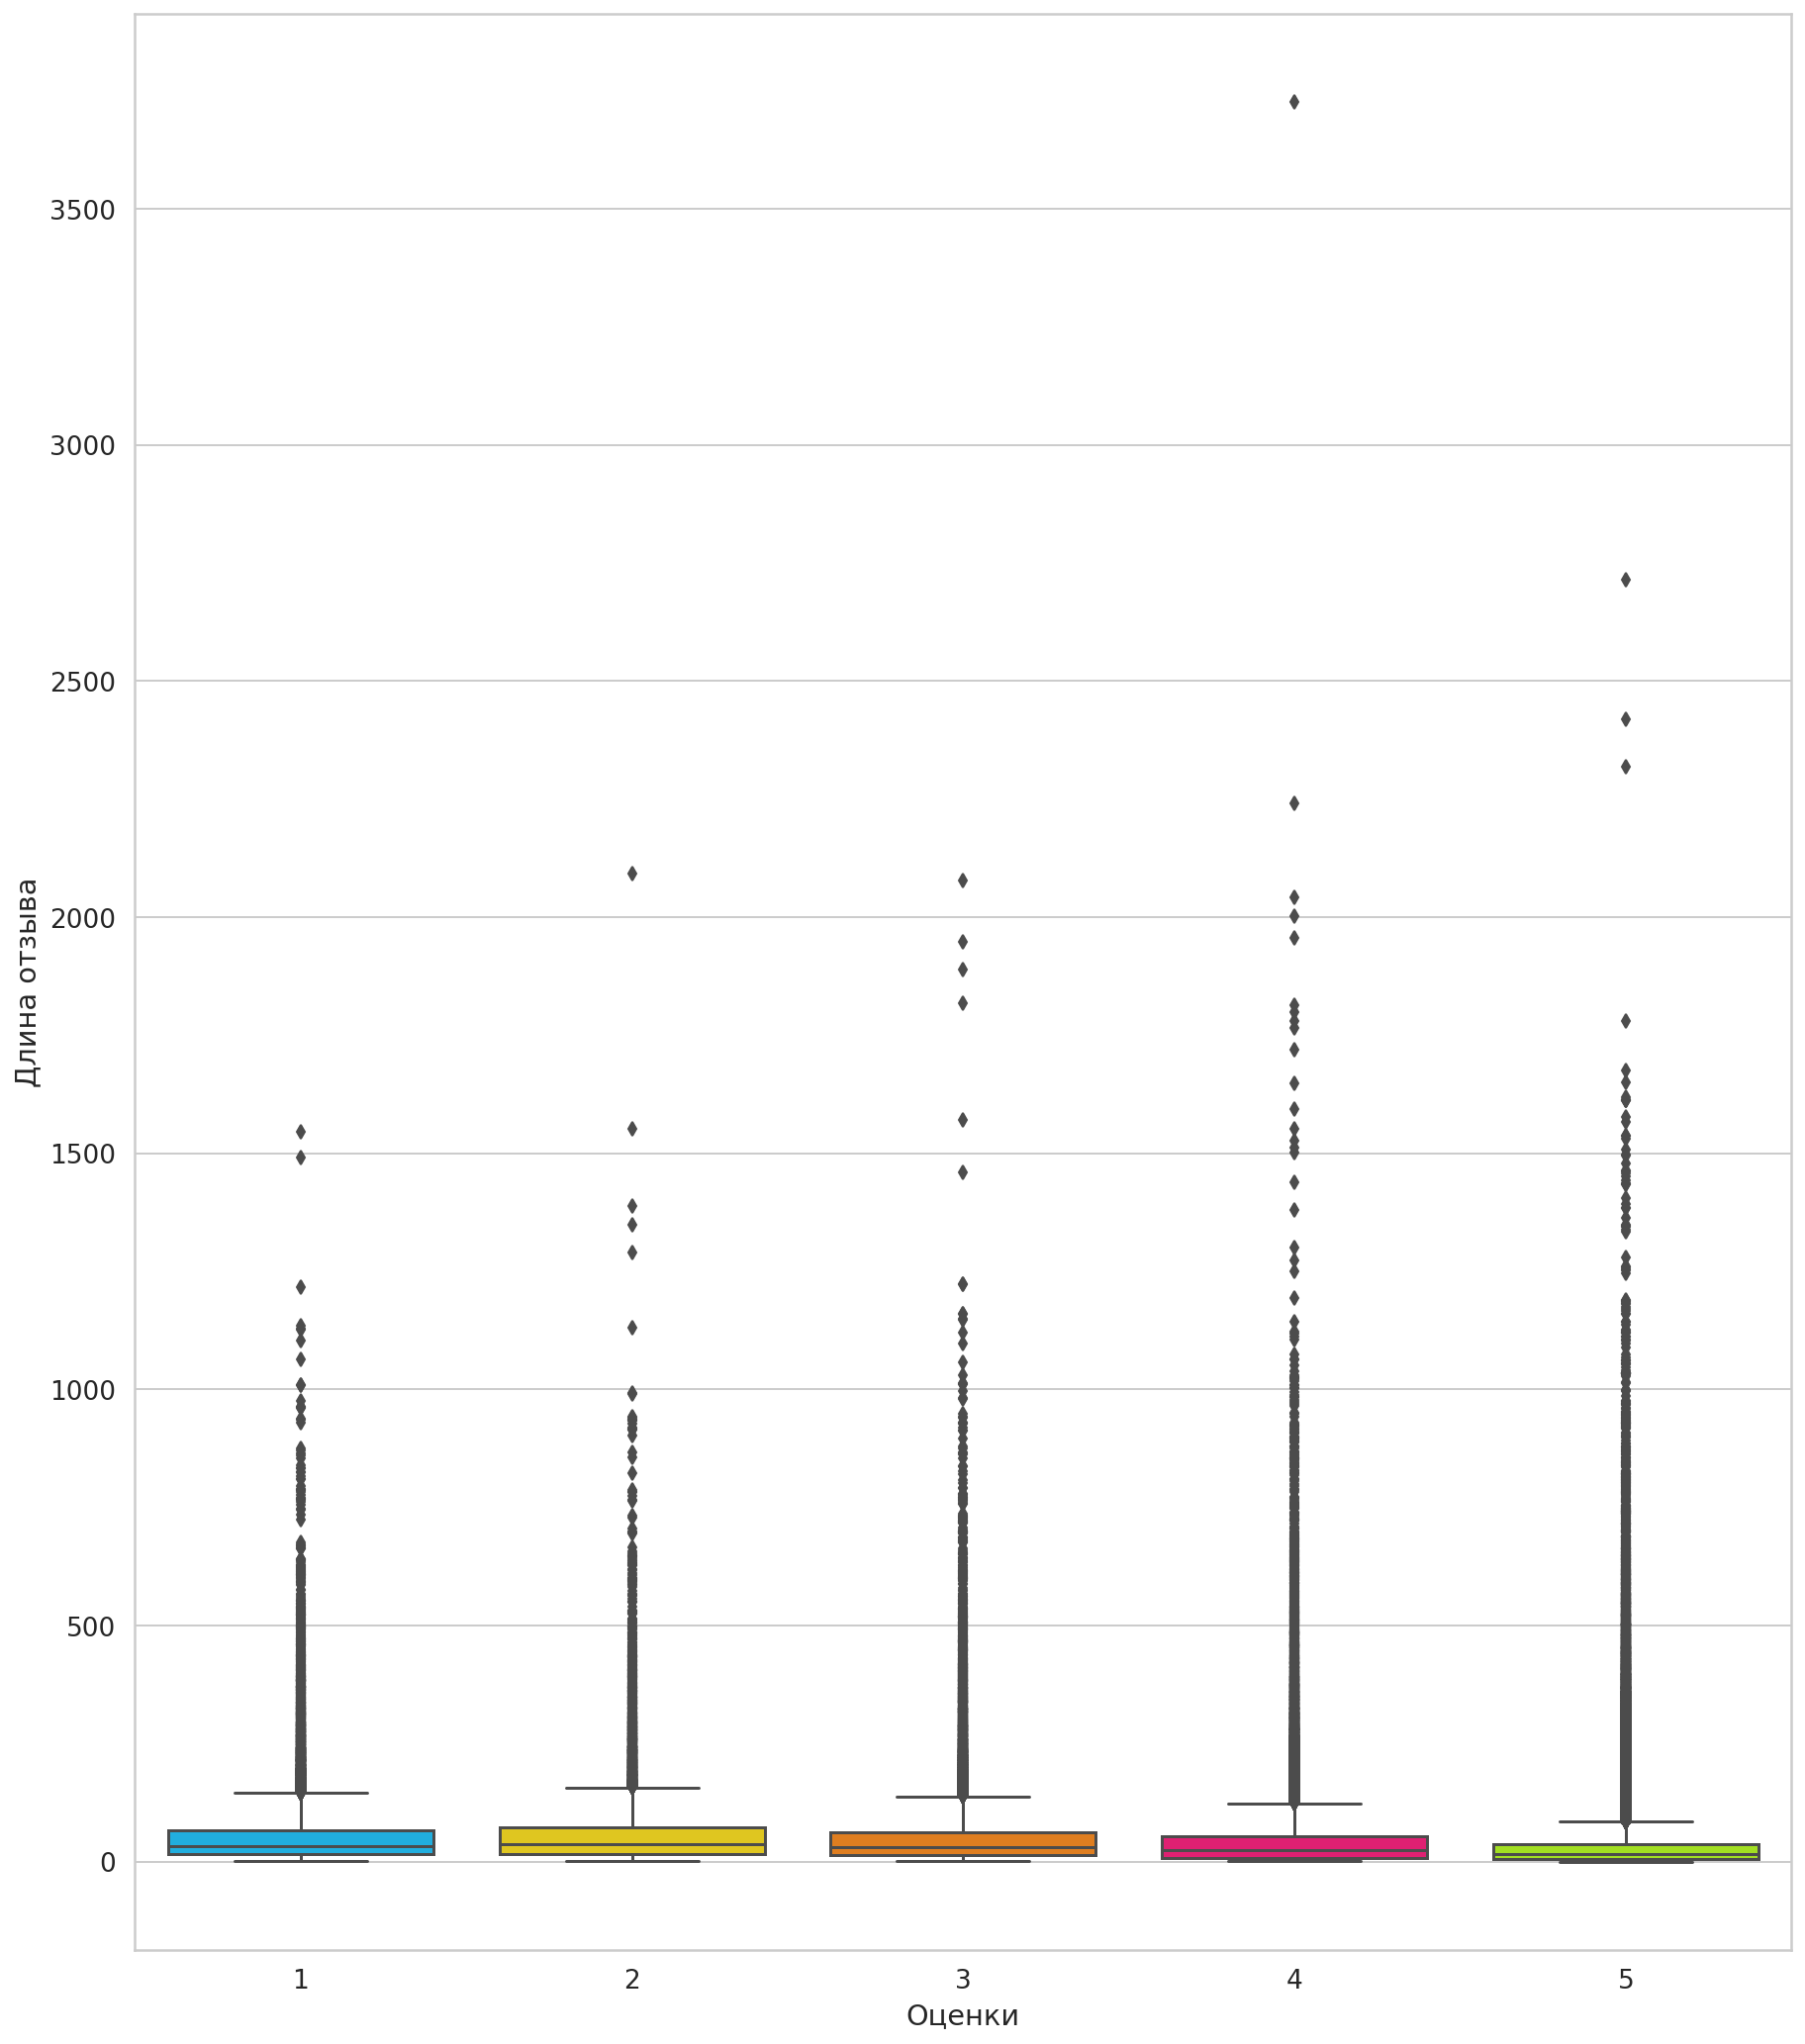

In [ ]:
plt.figure(figsize = (15,18))
sns.boxplot(x="overall",y=[len(str(rev).split()) for rev in reviews_am.reviewText],data=reviews_am)
plt.xlabel('Оценки')
plt.ylabel('Длина отзыва')

plt.show()

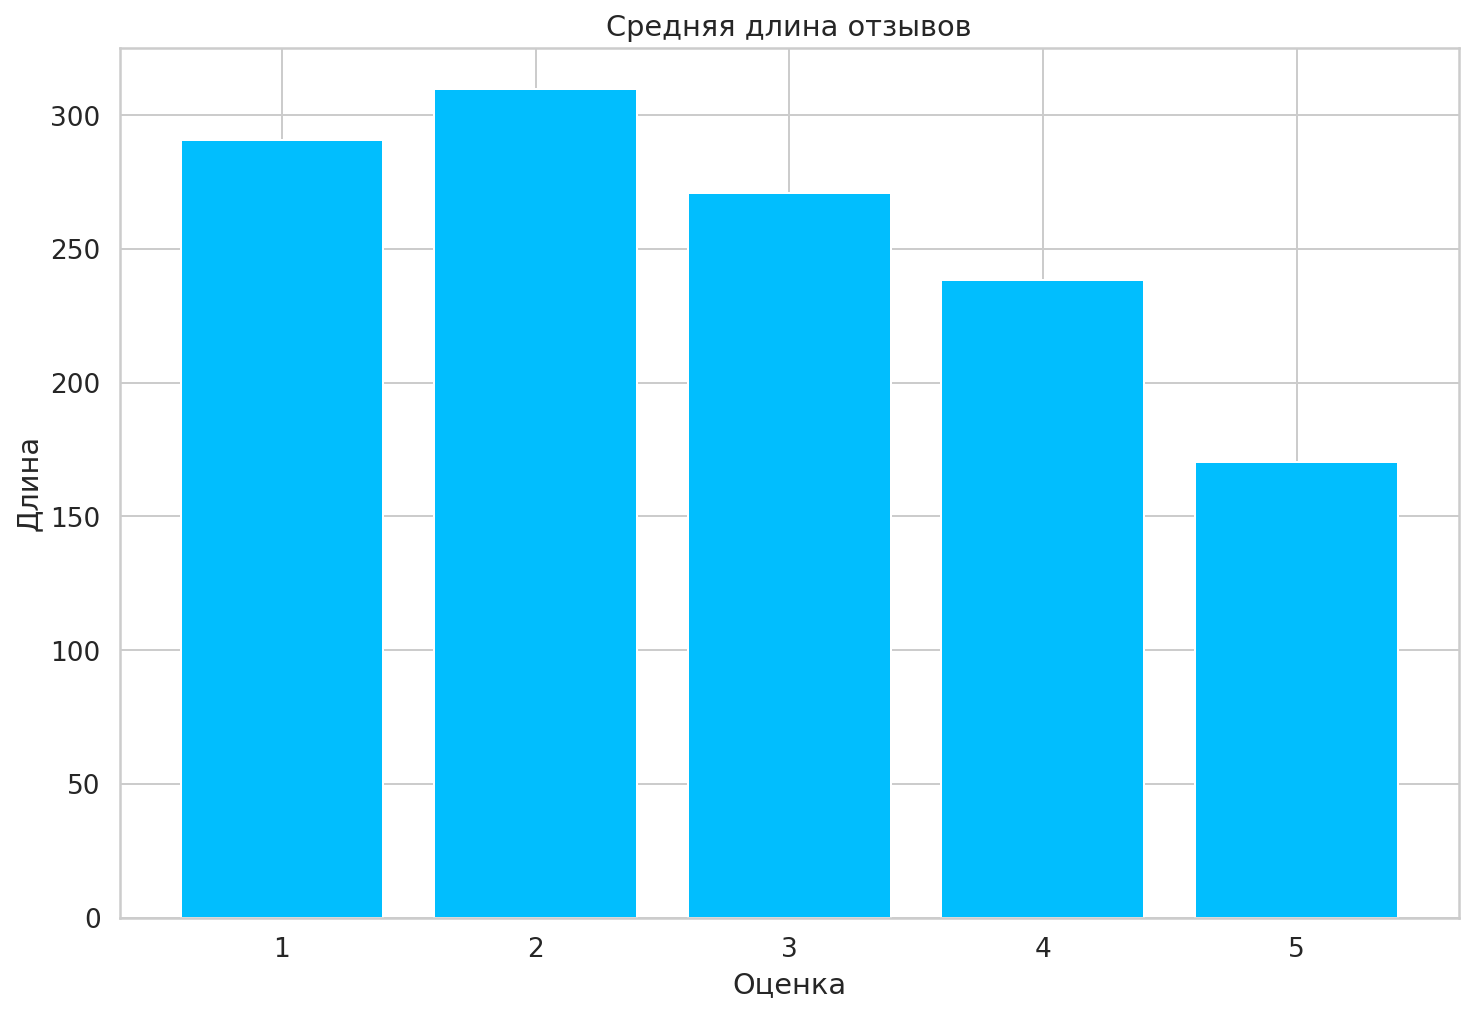

1 : 290.8376123387923
2 : 309.67285987150547
3 : 270.83078756546263
4 : 238.25050631260254
5 : 170.1535374071675


In [ ]:
plt.bar(np.arange(1,6), 
        [np.mean([len(str(i)) for i in reviews_am.loc[reviews_am.overall==k].reviewText.values]) for k in range(1,6)])
plt.title('Средняя длина отзывов')
plt.xlabel('Оценка')
plt.ylabel('Длина')
plt.show()

for k in range(1,6):
    print(k,':', np.mean([len(str(i)) for i in reviews_am.loc[reviews_am.overall==k].reviewText.values]))

In [ ]:
lengths = {}
for k in range(1,6):
    lengths[k] = np.mean([len(str(i)) for i in reviews_am.loc[reviews_am.overall==k].reviewText.values])

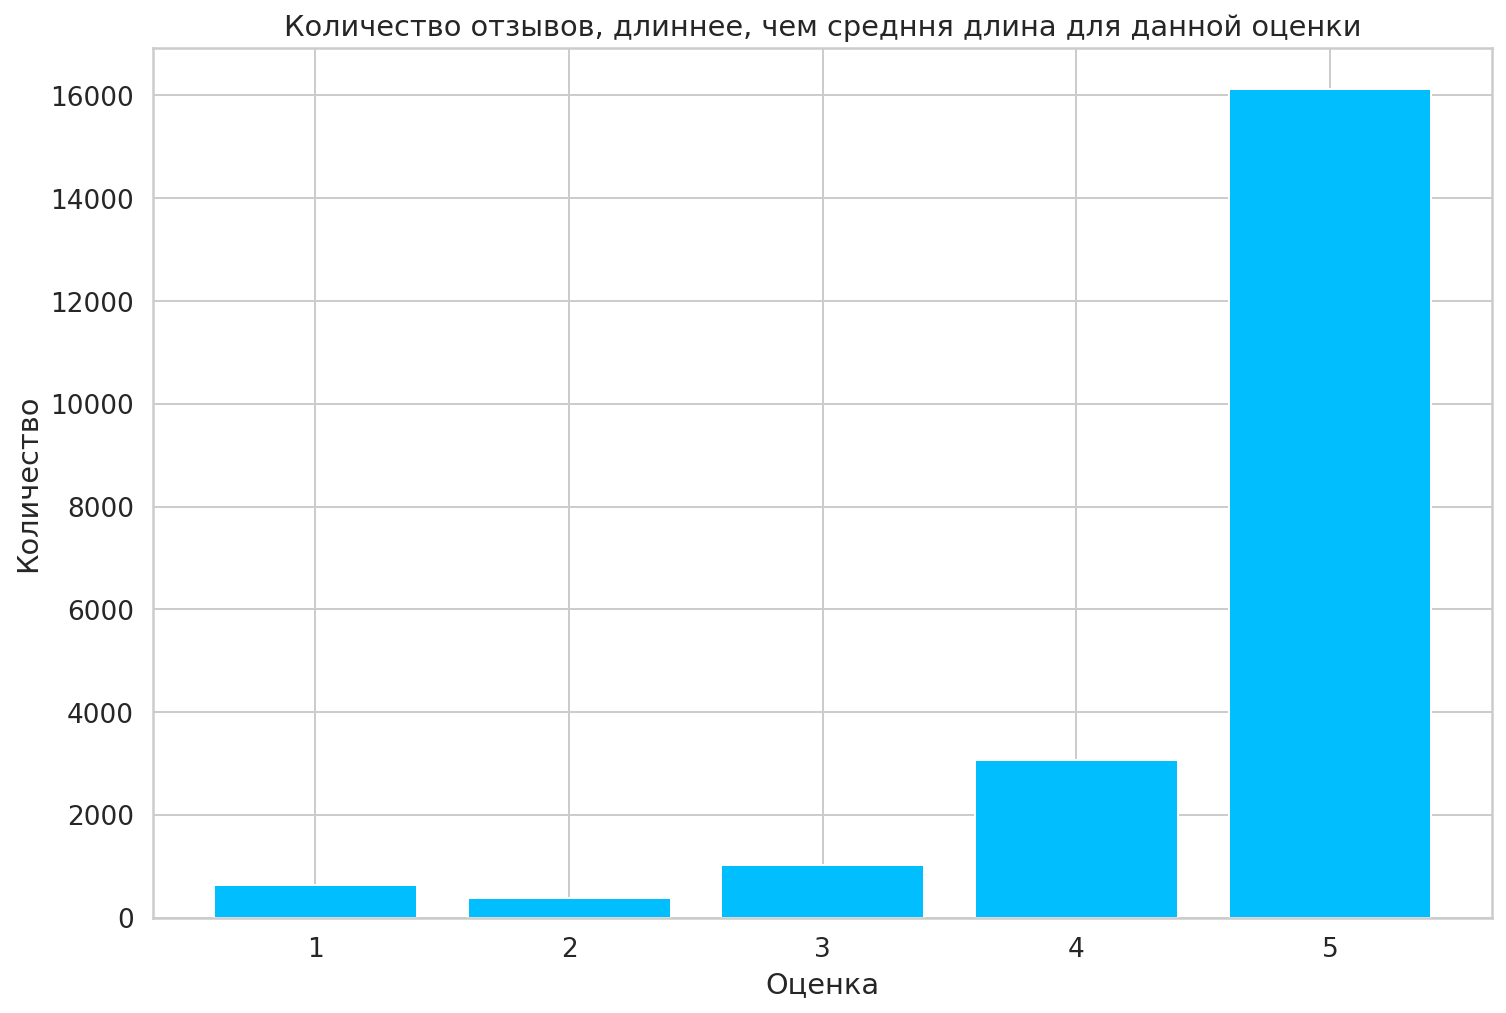

1 : 639
2 : 384
3 : 1033
4 : 3065
5 : 16120


In [ ]:
plt.bar(np.arange(1,6), 
        [len([i for i in reviews_am.loc[reviews_am.overall==k].reviewText.values if len(str(i).split())>lengths[k]]) for k in range(1,6)])
plt.title('Количество отзывов, длиннее, чем средння длина для данной оценки')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

for k in range(1,6):
    print(k,':', len([i for i in reviews_am.loc[reviews_am.overall==k].reviewText.values if len(str(i).split())>lengths[k]]))

Без аутлаеров

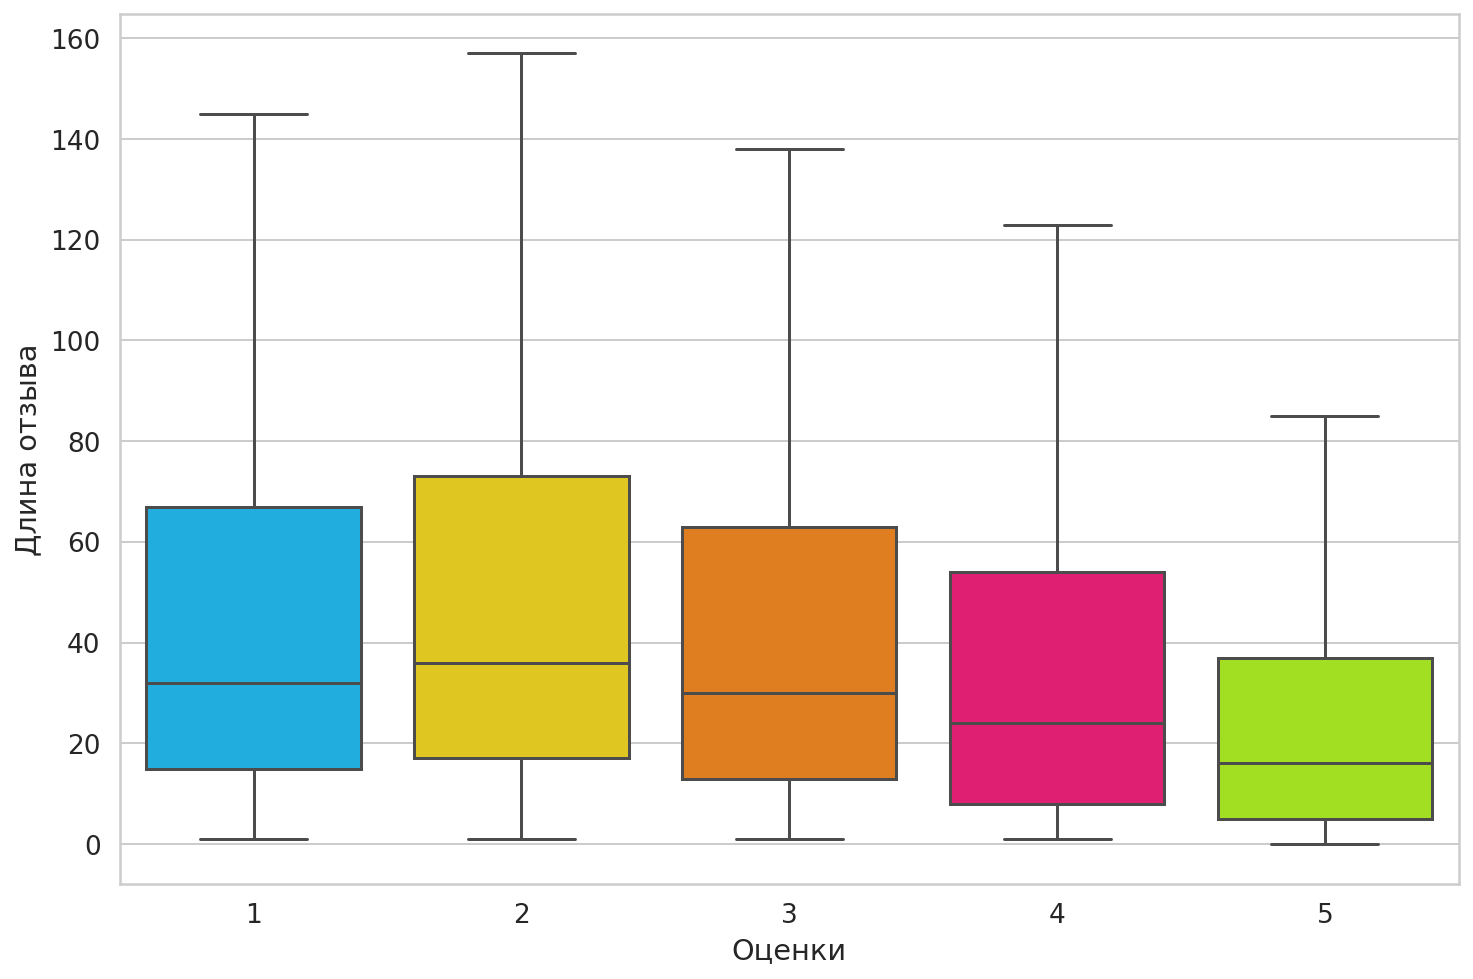

In [ ]:
sns.boxplot(x="overall",y=[len(str(rev).split()) for rev in reviews_am.reviewText],data=reviews_am, showfliers=False)
plt.xlabel('Оценки')
plt.ylabel('Длина отзыва')
plt.show()

In [ ]:
reviews_am['year'] = pd.to_datetime(reviews_am['reviewTime']).dt.year

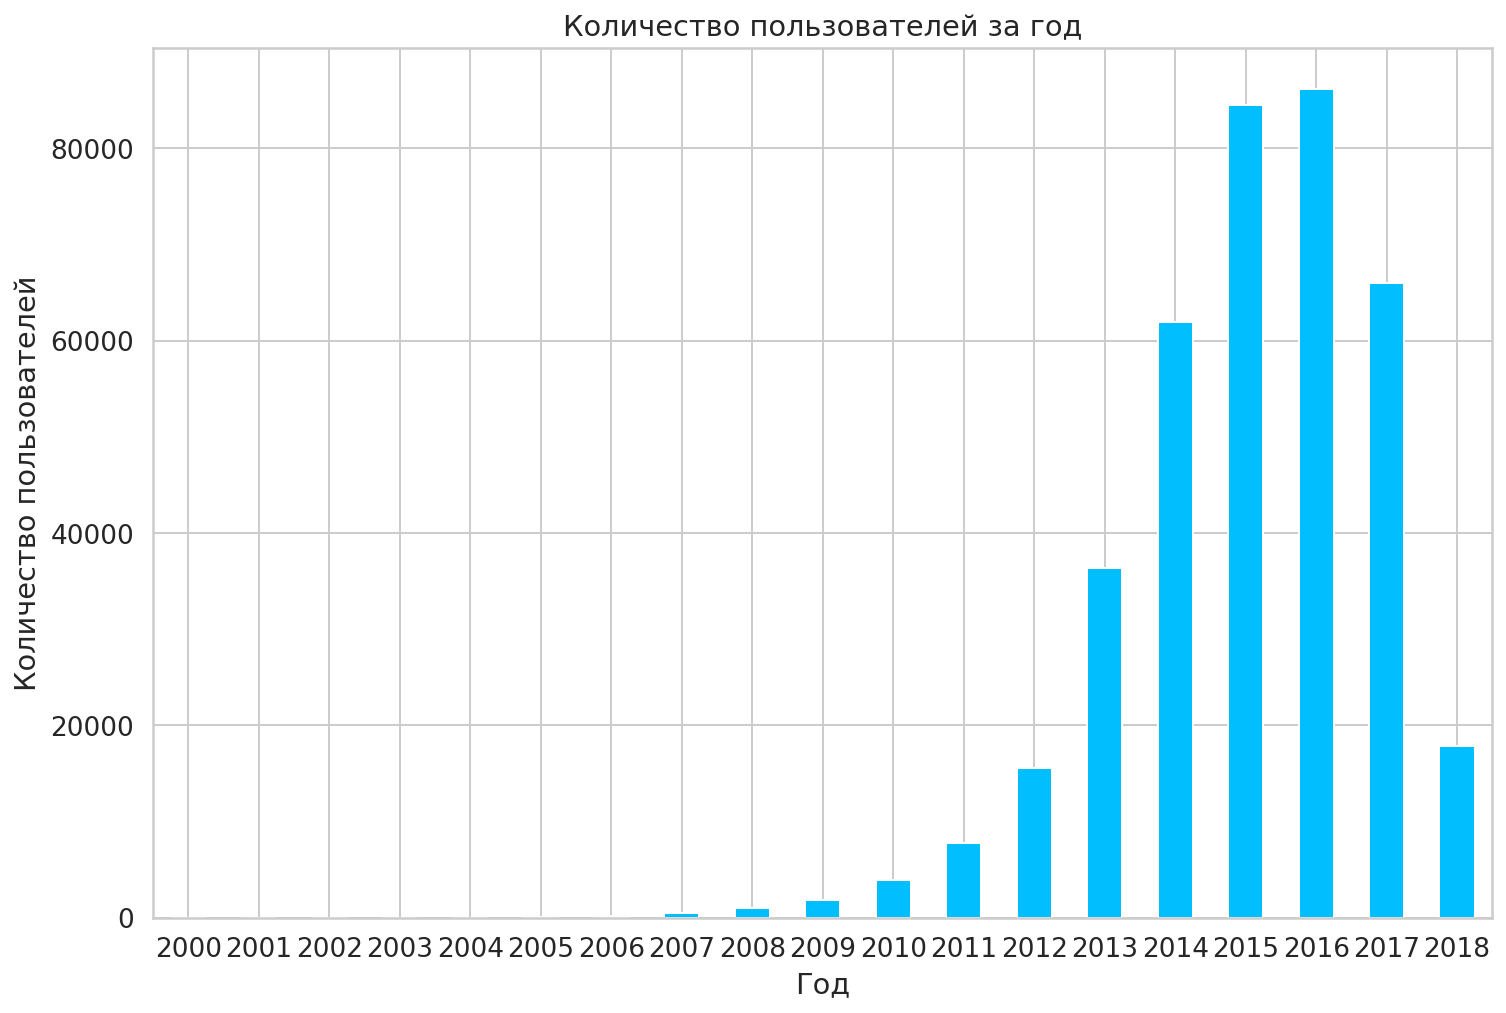

In [ ]:
unique_cust = reviews_am.groupby('year')['reviewerID'].nunique()

unique_cust.plot(kind='bar', rot = 0)
plt.title('Количество пользователей за год')
plt.xlabel('Год')
plt.ylabel('Количество пользователей')
plt.show()

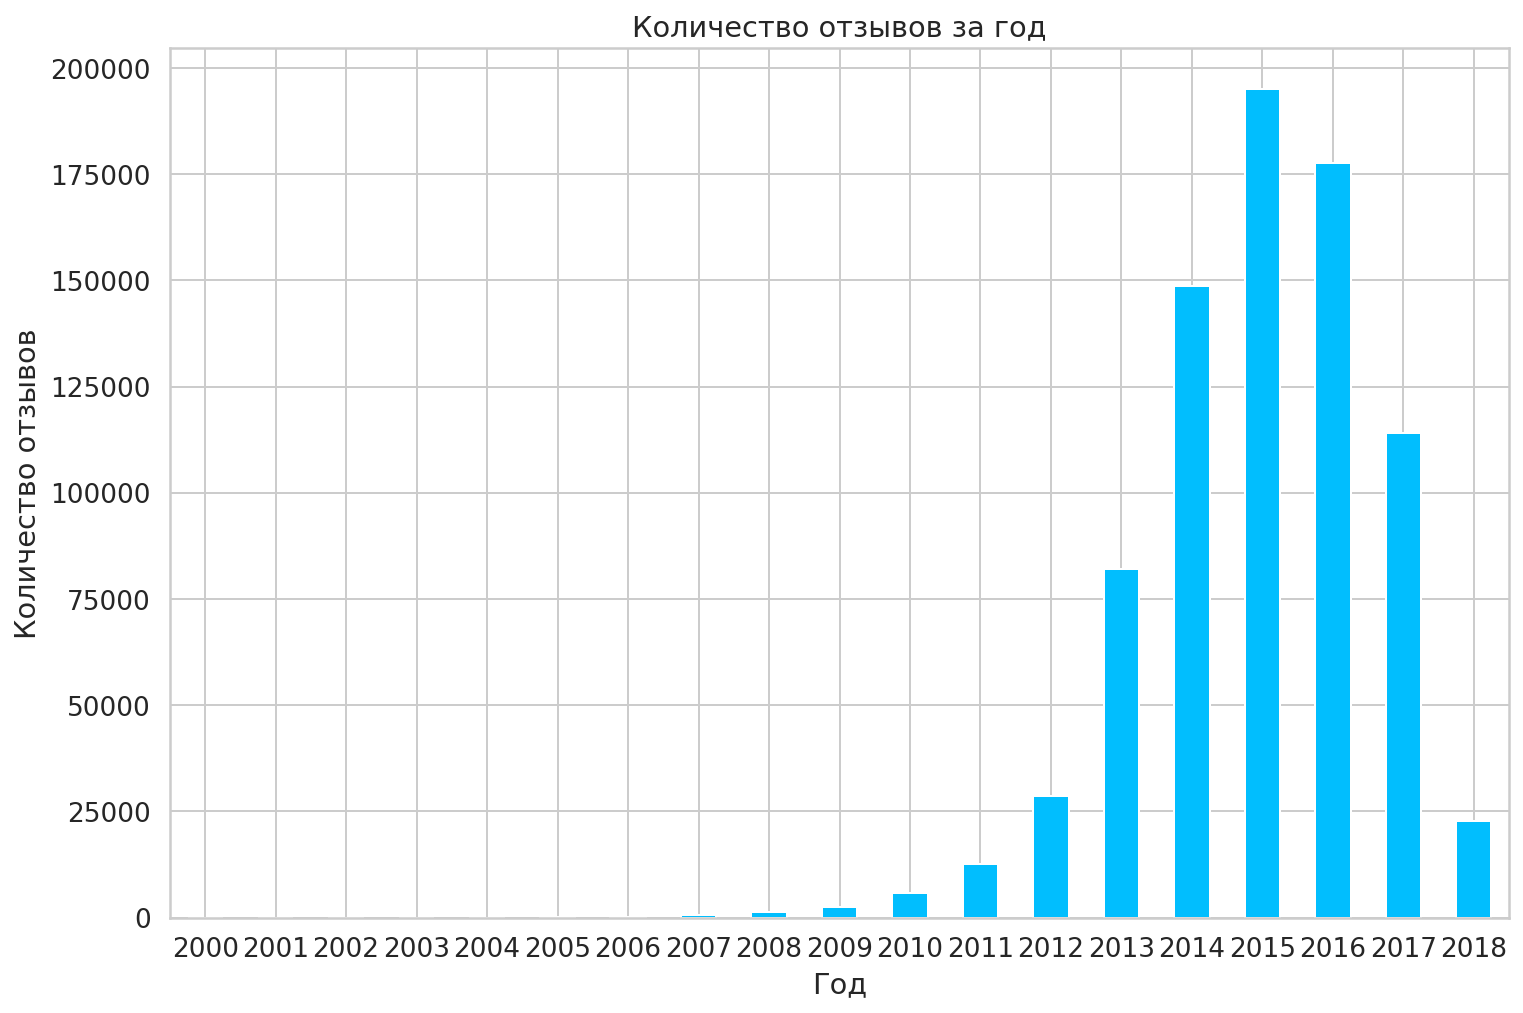

In [ ]:
unique_text = reviews_am.groupby('year')['reviewText'].nunique()

unique_text.plot(kind='bar', rot = 0)
plt.title('Количество отзывов за год')
plt.xlabel('Год')
plt.ylabel('Количество отзывов')
plt.show()

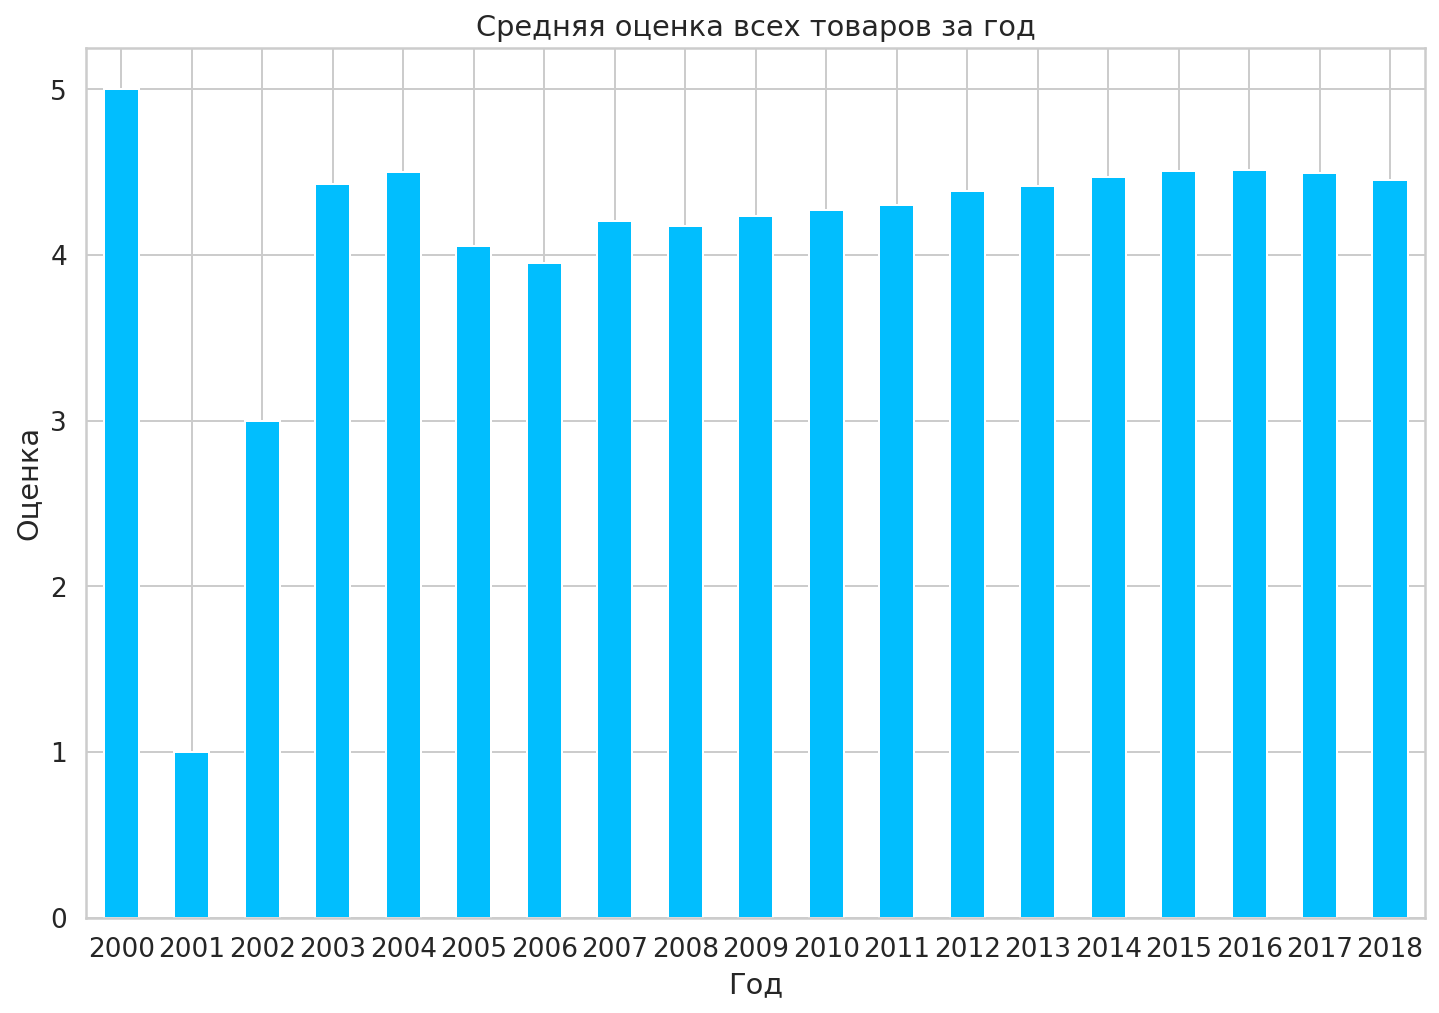

In [ ]:
mean_score = reviews_am.groupby('year')['overall'].mean()

mean_score.plot(kind='bar', rot = 0)
plt.title('Средняя оценка всех товаров за год')
plt.xlabel('Год')
plt.ylabel('Оценка')
plt.show()

Самые частые слова в отрицательных отзывах

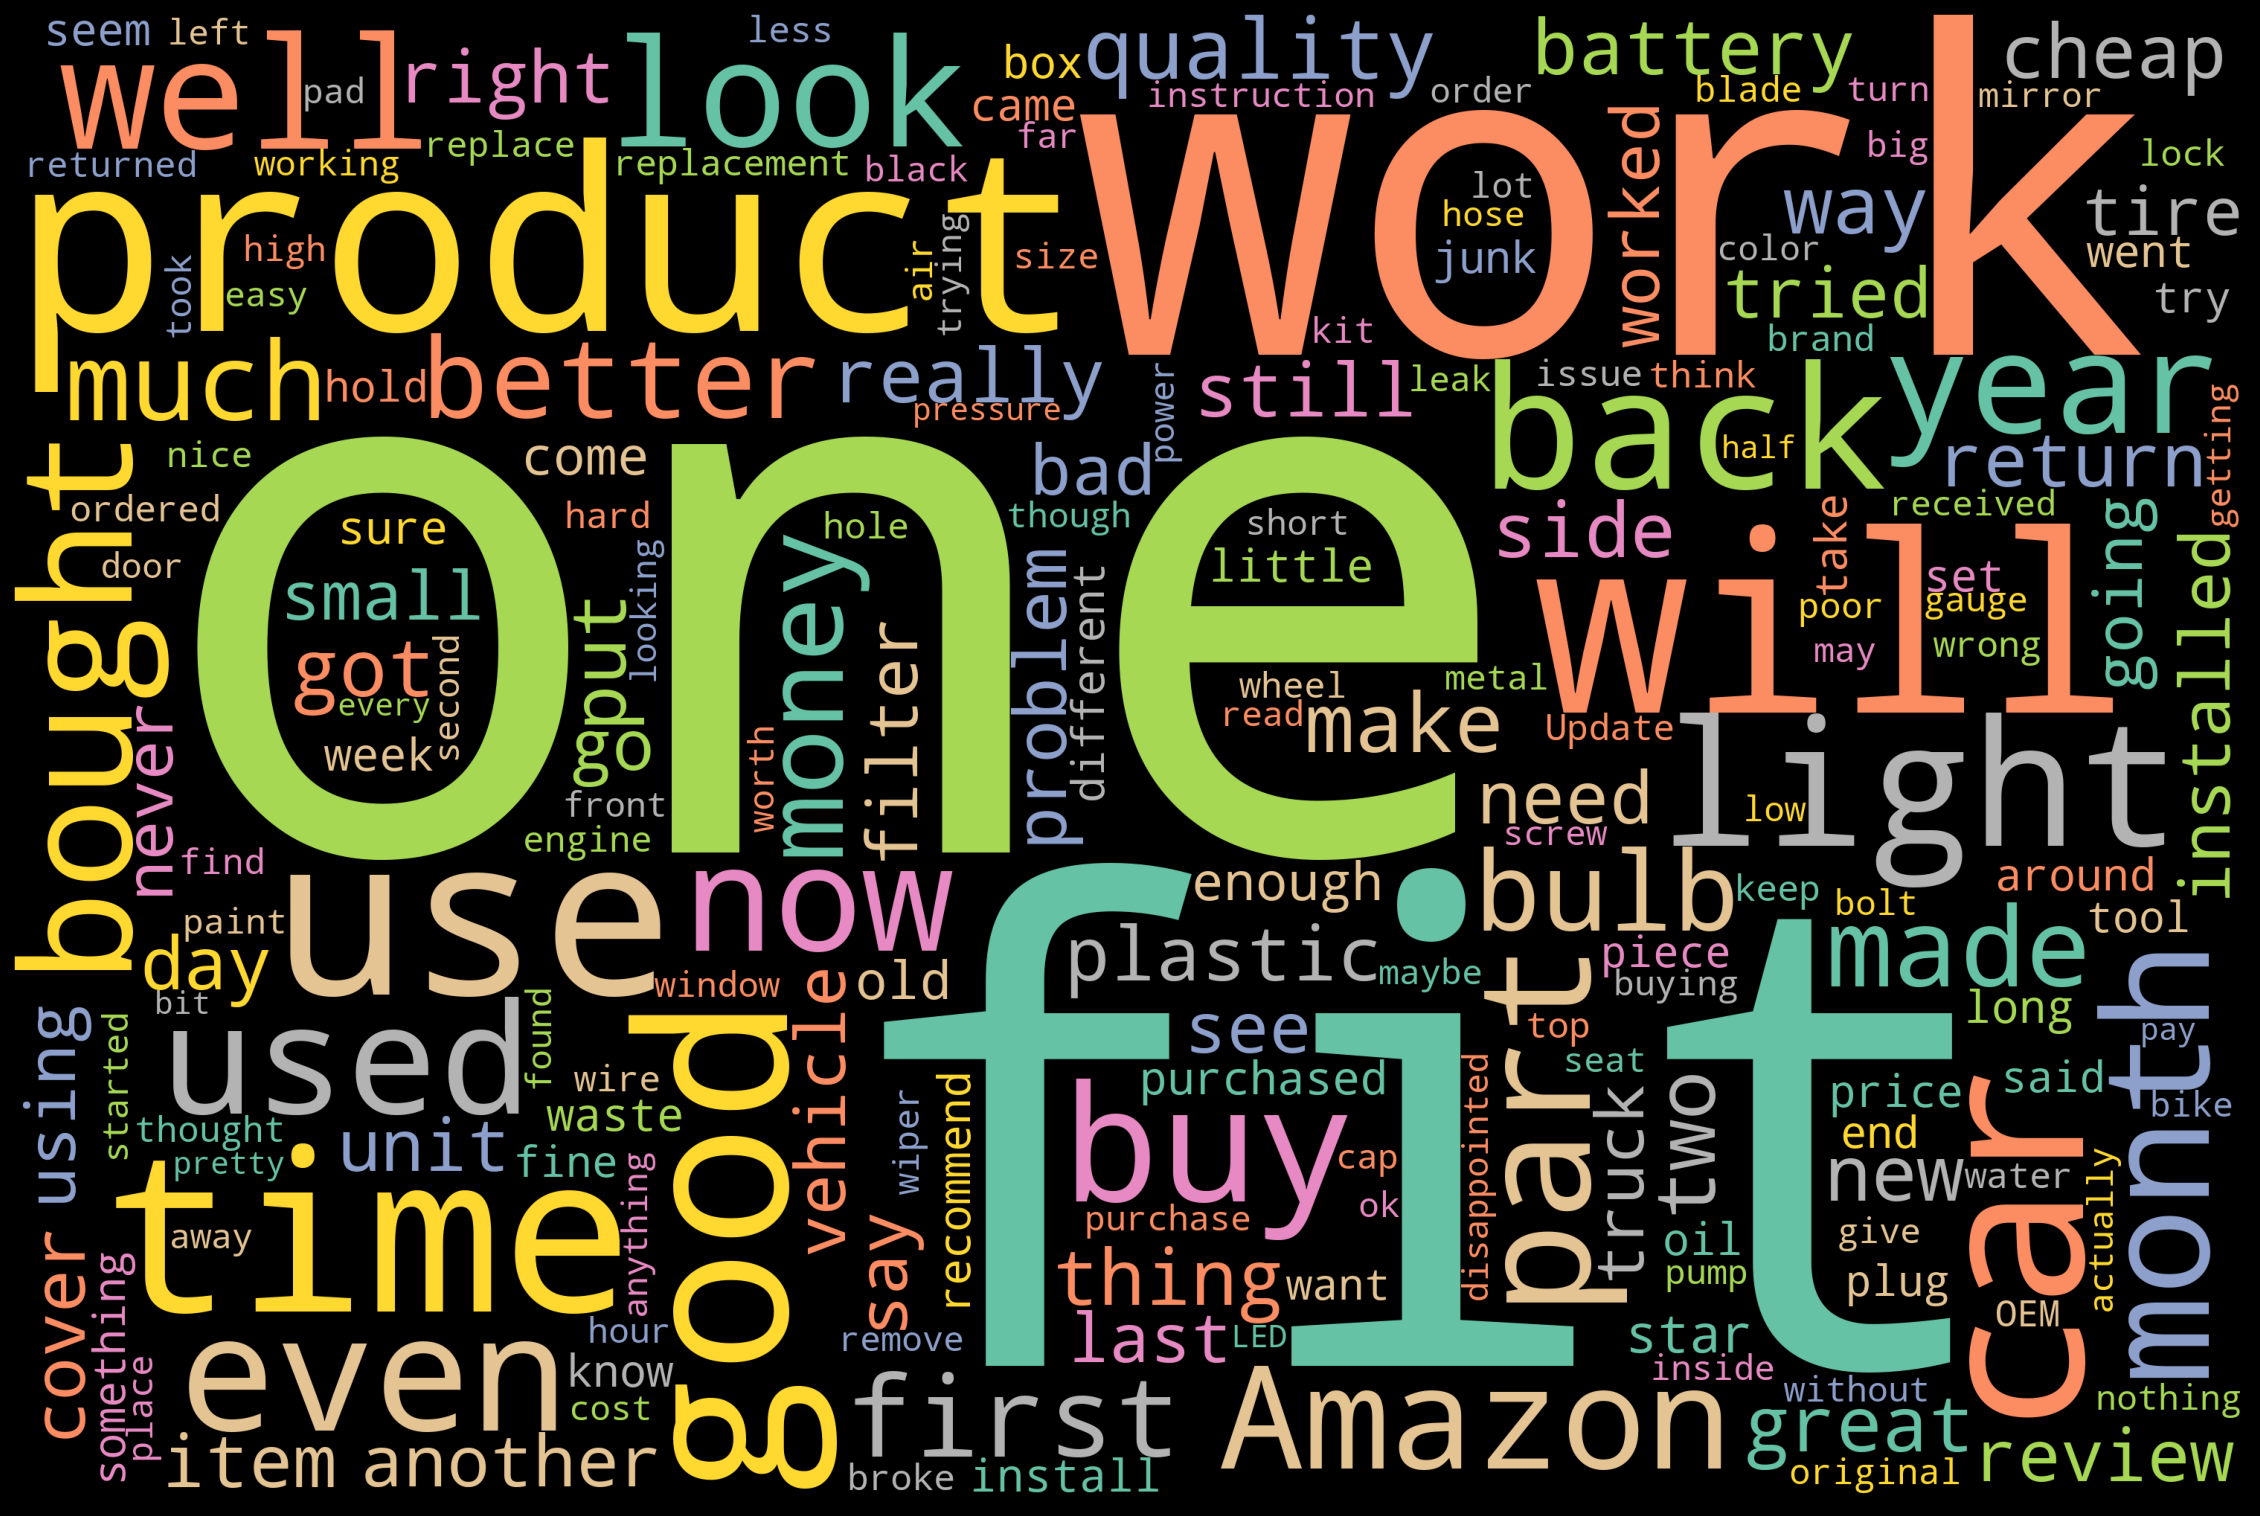

In [ ]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(20,20), facecolor='black')
plt.axis('off')
wordcloud_bad = WordCloud(width=3000, height=2000, background_color='black', colormap='Set2', \
                      collocations=False, stopwords=STOPWORDS).generate(' '.join([str(i) for \
                      i in reviews_am.loc[reviews_am.overall.isin([1,2])].reviewText.values]))
plt.imshow(wordcloud_bad)

Самые частые слова в положительных отзывах

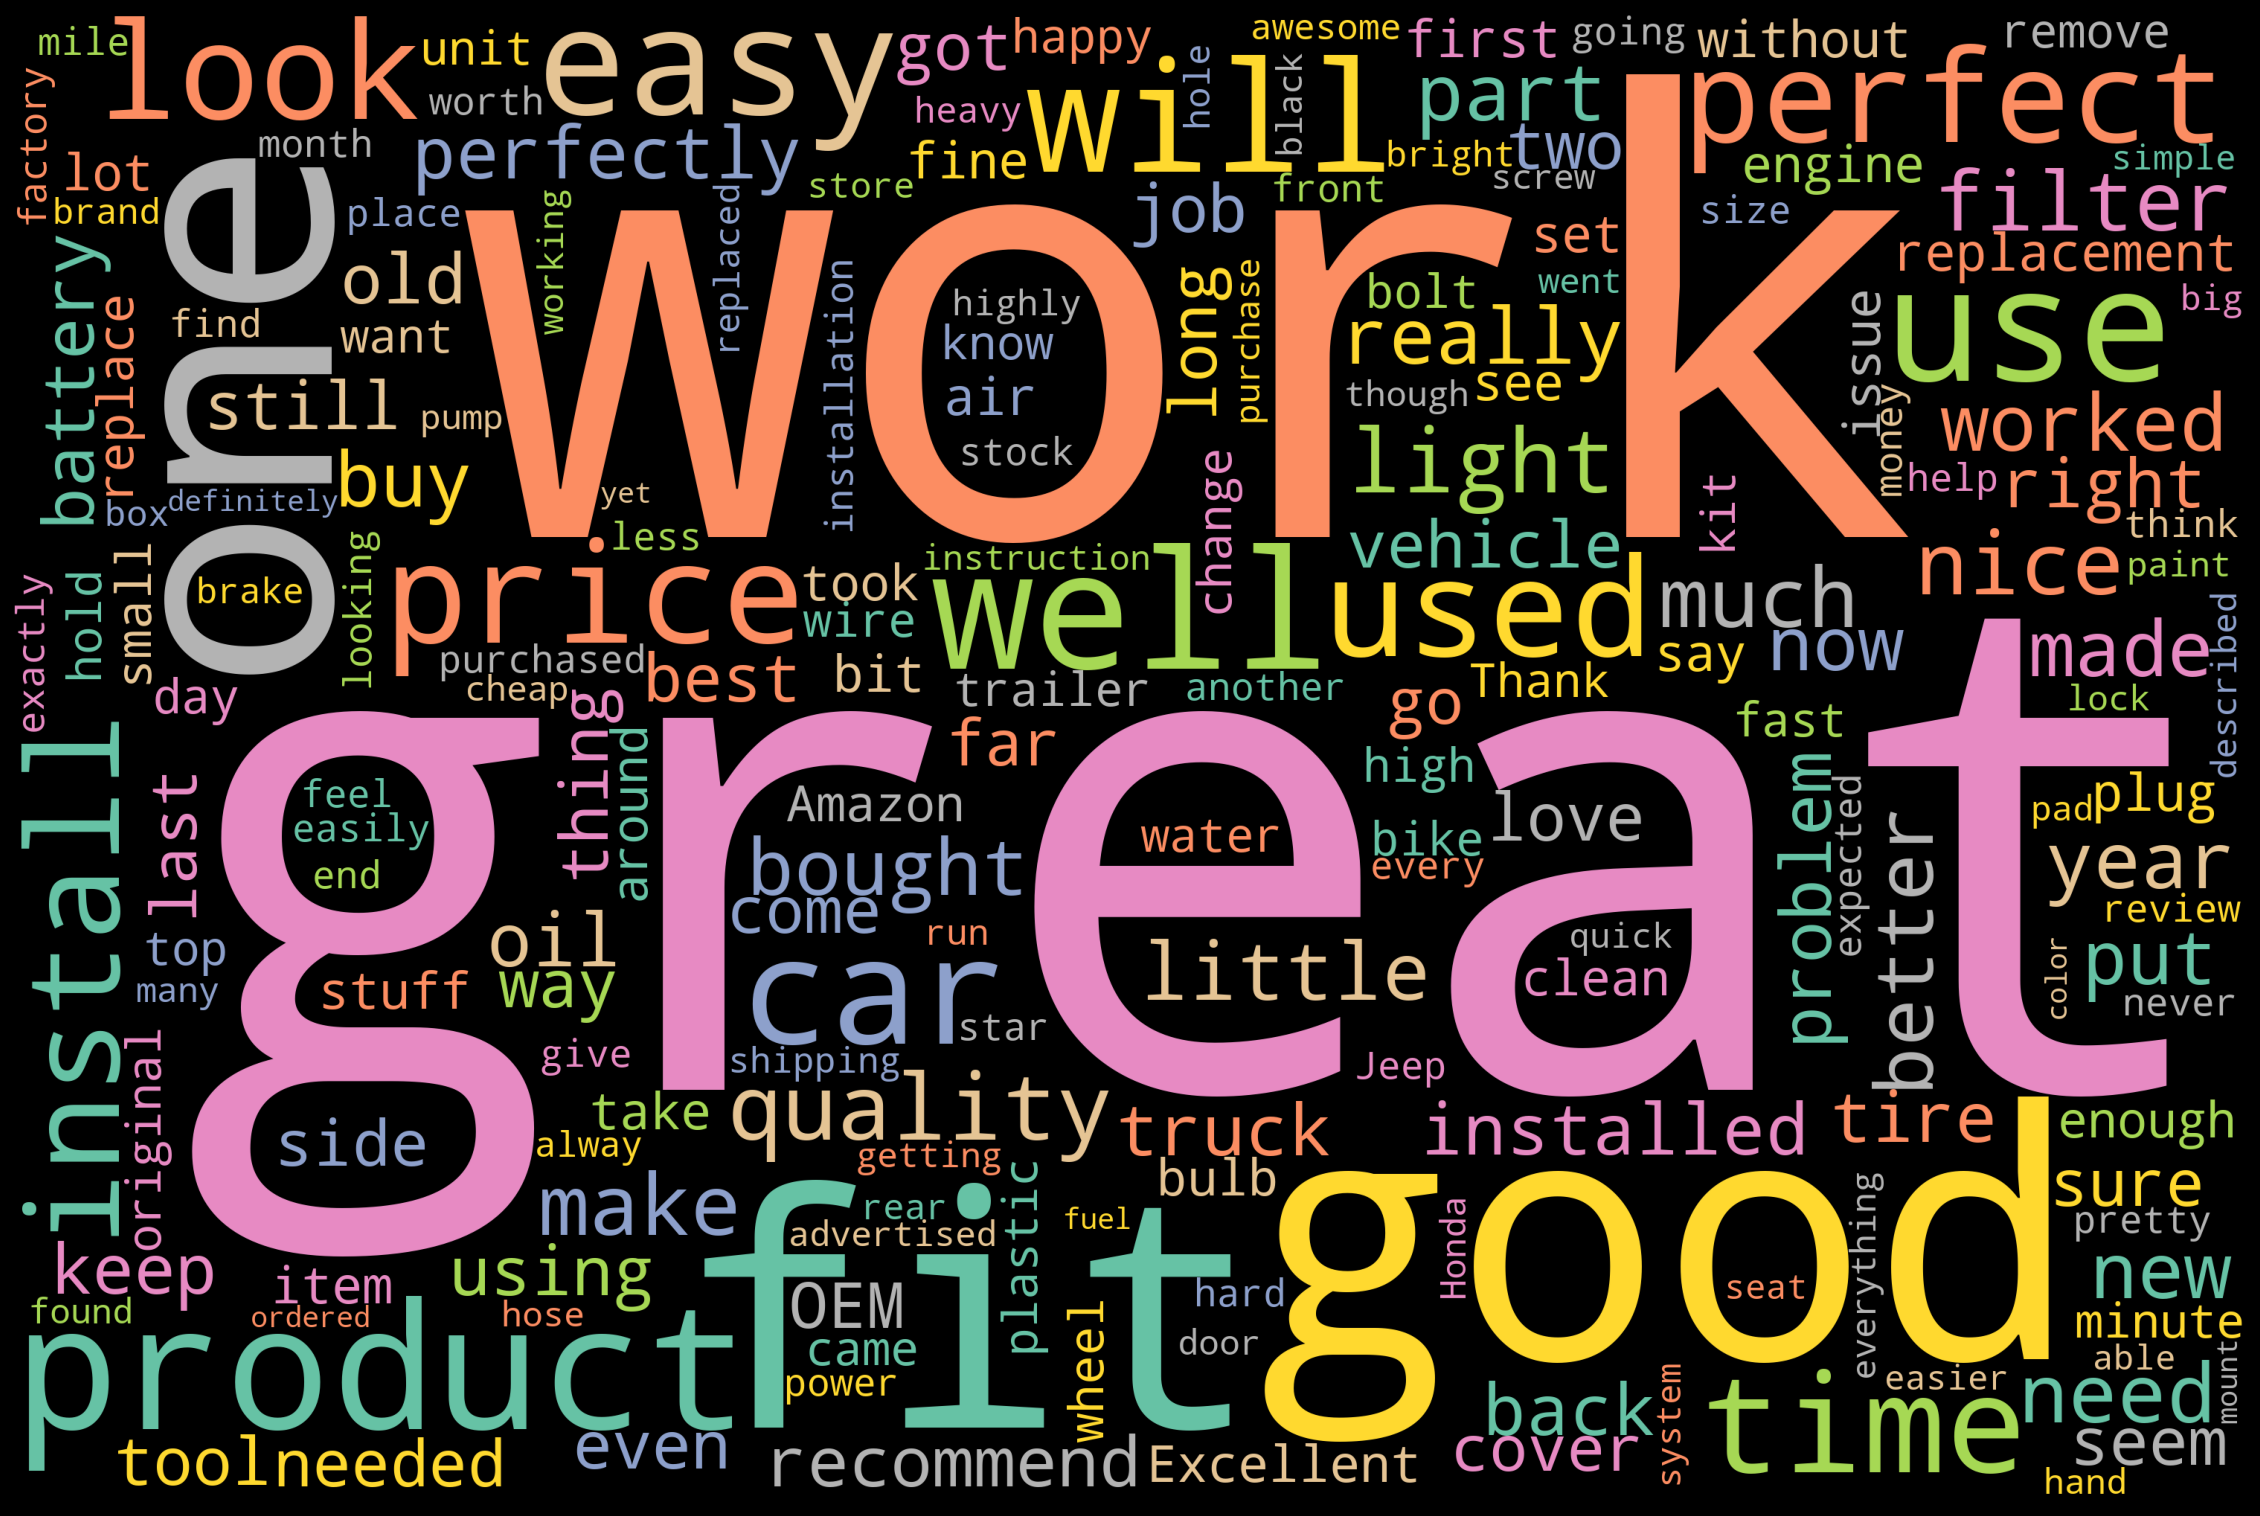

In [ ]:
plt.figure(figsize=(20,20), facecolor='black')
plt.axis('off')
wordcloud_good = WordCloud(width=3000, height=2000, background_color='black', colormap='Set2', \
                      collocations=False, stopwords=STOPWORDS).generate(' '.join([str(i) for \
                      i in reviews_am.loc[reviews_am.overall.isin([4,5])].reviewText.values]))
plt.imshow(wordcloud_good)

In [ ]:
reviews_am = reviews_am[['overall',	'verified',	'reviewTime', 'reviewerID',	'asin',	'reviewerName',
         'reviewText', 'summary']]
reviews_am.drop_duplicates(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Переводим оценки в подходящий для классификации формат (0,1,2,3,4)

In [ ]:
reviews_am.overall = reviews_am.overall-1

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
reviews_am.overall.unique()

array([3, 0, 2, 4, 1])

Для классификации использовались поля reviewText и summary

In [ ]:
reviews_am = reviews_am.loc[(reviews_am.overall.notna())&(reviews_am.reviewText.notna())&(reviews_am.summary.notna())]

Конкатенируем в единое текстовое поле

In [ ]:
reviews_am['combined'] = reviews_am.summary + ' ' + reviews_am.reviewText

In [ ]:
reviews_am

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,combined
0,3,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,Works well if you place phone in horizontally ...
1,0,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,noe,It sucks barely picks up anything definitely n...,sucks,sucks It sucks barely picks up anything defini...
2,0,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,"Defective Well to write a short one, it blew 2..."
3,2,True,"04 13, 2018",A1X77G023NY0KY,0209688726,Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,Looks cool! Probably works I have absolutely n...
4,4,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,danny,it ok it does it job,Five Stars,Five Stars it ok it does it job
...,...,...,...,...,...,...,...,...,...
999995,4,True,"01 7, 2015",A2I6GN7OHB9JKF,B00DVH64HW,ktr,works great. just what i needed to see what a...,works great. just what i needed to see what am...,works great. just what i needed to see what am...
999996,4,True,"11 14, 2014",A1SF2ZAPHIIKUU,B00DVH64HW,KOSMOLENYA,"Really good, just need to be calibrated. I ext...",Five Stars,"Five Stars Really good, just need to be calibr..."
999997,4,True,"07 4, 2014",A23BUI9NSDYUTY,B00DVH64HW,Dsinned,"Last year, I bought several of these on Ebay, ...",Nice product at a bargain price!!!,"Nice product at a bargain price!!! Last year, ..."
999998,4,True,"05 20, 2014",A3TIYYLNB9XN5E,B00DVH64HW,R. Jones,This is a great product. Well manufactured an...,Digital meter.,Digital meter. This is a great product. Well ...


В ходе эксперимента проверялись разные подходы к классификации. В частности, использовались разные способы очистки/форматирования текста, выбор разных фич для классификации, применение разных моделей. Способ, на котором было решено остановиться, заключается в дообоучении RoBERTa на сыром тексте полей summary + reviewText. Из опыта, модели-трансормеры лучше работают с нетронутым текстом. Проверял также BERT, и простые нейронки ConvNet и LSTM. При условии жесткого форматирования текста (знаки препинания, нижний регистр, лемматизация), а также даунсемплинга (удаления части 5-бальных оценок для избегания перекоса) нейронка на основе конволюшена давала результат на 4-5% ниже по общей точности на тесстовом сете в сравнении с RoBERTa.

Также пытался учесть остальные фичи, присутствующие в датасете, путем обучения классических алгоритмов (XGBoost, LogReg, KNN, NaiveBayes, Random Forest) на результатах прогноза RoBERTa на validation set (т.е. использовать прогноз трансформера как фичи вместе с временем оценки, ид пользователя и товара и тд). Перепробовал различные способы енкодинга данных, выбора фич, тюнинг гиперпараметров, но использование упомянутых алгоритмов при таком подходе только ухудшало результат на тестовом сете.

Еще была идея переформатировать задание в рекомендательную систему, используя лишь коды товаров и пользователей, но отбросил ее из-за большого количества уникальных товаров и пользователей и выхода за рамки NLP.

Ниже представлено только использование RoBERTa.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import defaultdict
from textwrap import wrap

!pip install transformers==3

import transformers
from transformers import BertModel, BertTokenizer, AdamW,  \
get_linear_schedule_with_warmup, BertForSequenceClassification, RobertaModel, RobertaTokenizer


import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 757kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 27.6MB/s 
     |████████████████████████████████| 3.0MB 33.3MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=adf7f2c3a7e927ad72dc436a6b0e55c37d3a11fce5489ed168a54dfc3db26fc4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
from tqdm import tqdm

In [8]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Max length:  512
                                        


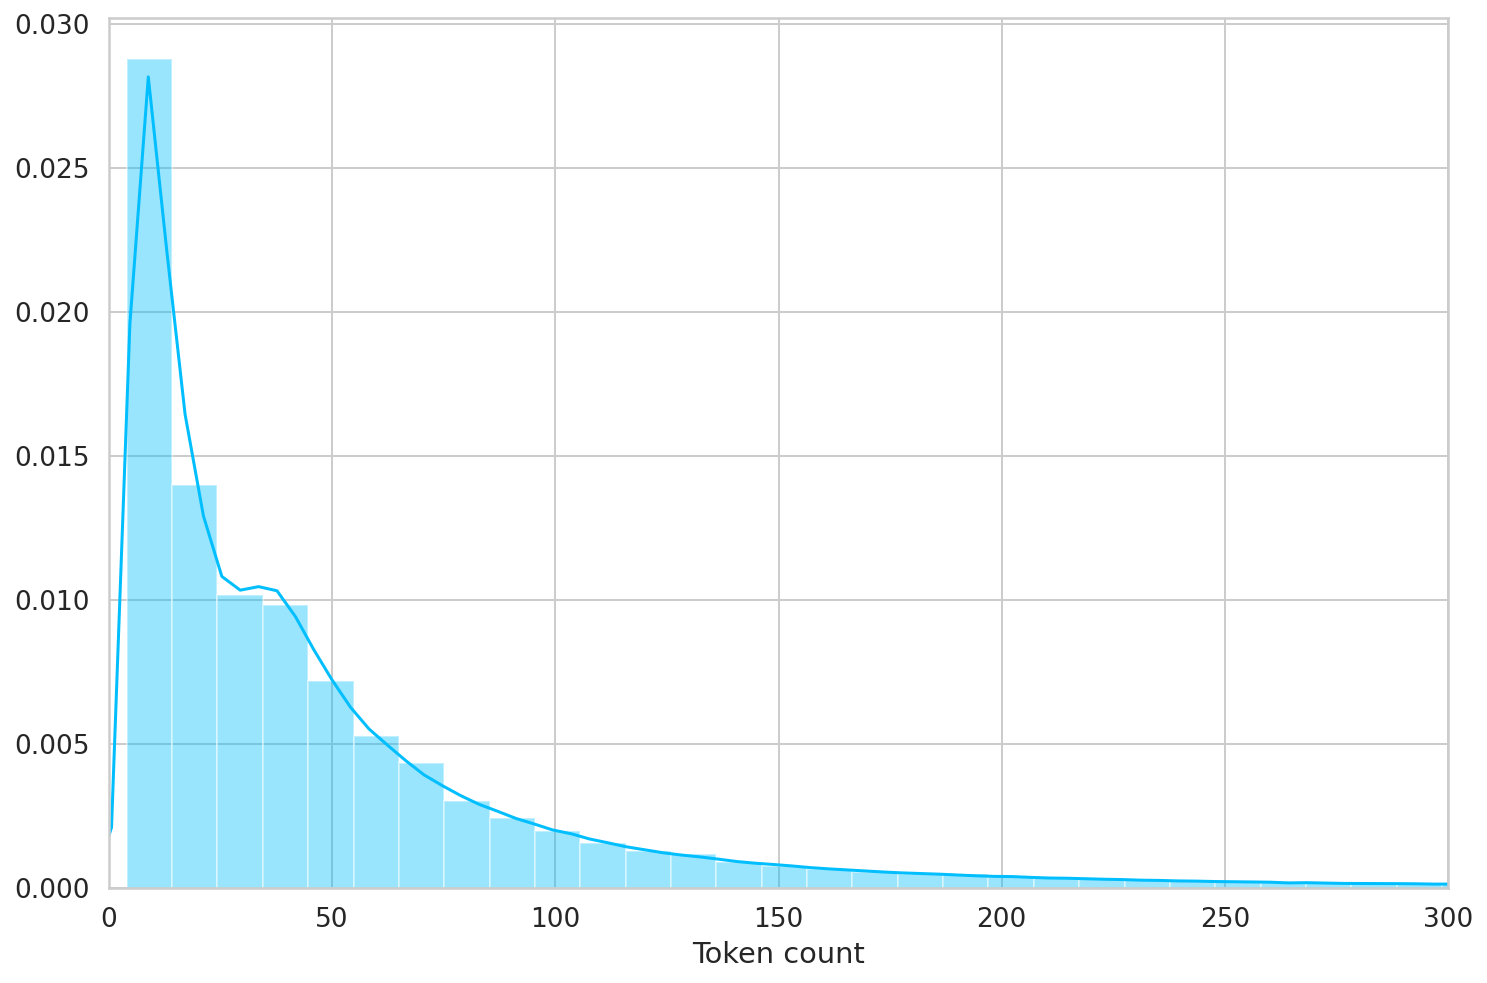

In [ ]:
token_lens = []

for review in list(reviews_am.combined):
  tokens = tokenizer.encode(review, truncation=True, max_length=512)
  token_lens.append(len(tokens))

print('Max length: ', max(token_lens))
print(' '*40)

sns.distplot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count');

Устанавливаем максимальную длину отзыва в 192 токена (согласно токенизатору Роберты). Также пробовал 128.

In [ ]:
MAX_LEN = 192

In [ ]:
class ReviewDataset(Dataset):

  def __init__(self, reviews, labels, tokenizer, max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len, # 192
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

Первые 700000 рядов для обучения

In [ ]:
df_train = pd.DataFrame({'text': reviews_am.combined[:700000], 'label': reviews_am.overall[:700000]})
df_test = pd.DataFrame({'text': reviews_am.combined[700000:], 'label': reviews_am.overall[700000:]})

In [ ]:
df_test.shape

(234333, 2)

Train set, Validation set, Test set

In [ ]:
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((700000, 2), (117166, 2), (117167, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.text.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Как данные представлены в даталоадерах. Текст отзыва, токенизированный текст, маска, указывающая, являются ли токены реальными словами (1) или zero-padding (0) - правда, у роберты one-padding, ноль указывает на начало предложения, - а также лейбл (в данном случае 4 звезды).

In [ ]:
print([i for i in train_data_loader][0]['review_text'][0])
print([i for i in train_data_loader][0]['input_ids'][0])
print([i for i in train_data_loader][0]['attention_mask'][0])
print([i for i in train_data_loader][0]['labels'][0])

Works well if you place phone in horizontally (landscape mode).  Needs instructions / more photos here on Amazon After I wrote the below review, the manufacturer contacted me and explained how to use this.  Instead of the (current) picture on Amazon where the phone is placed vertically, you actually use the stand with the phone placed horizontally.  Then the charge / sync cable goes through the hole and you can charge from the side.  When used in landscape position this stand does make more sense so I'm upgrading this review from 2 stars to 4 stars (which I rarely do, but in this case user error) with a star off for lack of documentation.  Manufacturer has said he will include directions and I would also encourage him to update the photos on Amazon with more examples of how this can be used.  The wood quality is indeed good and it's a sturdy little stand.  I'm trying to think of when I'd actually use this stand... perhaps for Facetime chats.  I also think it would be useful for someone

In [ ]:
data = next(iter(train_data_loader))

#print(data['review_text'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([32, 192])
torch.Size([32, 192])
torch.Size([32])


In [9]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Архитектура финальной модели. За готовым трансформером следует 0.3 дропаут и линейный слой из 5 нейронов поверх последнего из 768. Несмотря на то, что для мультиклассовой классификации huggingface предоставляет версию RobertaForSequenceClassification, из моего опыта использования Берта, а также туториалов в интернете, надежнее впиывать последний слой вручную.

In [ ]:
class AmazonClassifier(nn.Module):

  def __init__(self, n_classes):
    super(AmazonClassifier, self).__init__()
    self.roberta = roberta_model
    self.drop = nn.Dropout(.3)
    self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device

device(type='cuda', index=0)

Дерево архитектуры. От Берта Роберта отличается в осноном лишь embeddings, алгоритмом токенизации и особенностями pre-training (собственно, RoBERTa = Robustly Optimized BERT Pretraining Approach).

In [ ]:
model = AmazonClassifier(5)
model = model.to(device)

print(model)

AmazonClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 192])
torch.Size([32, 192])


Обучаем 2 эпохи. Из-за размеров датасета это максимально доступное количество, но в целом вполне достаточно 1 эпохи.

In [ ]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Вспомогательные функции для обучения и тестирования.

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  y_pred_tr = []
  y_true_tr = []

  losses = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    
    loss = loss_fn(outputs, labels)
    
    for i in preds.cpu().numpy():
      y_pred_tr.append(i)
    for i in labels.cpu().numpy():
      y_true_tr.append(i)
    
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return accuracy_score(y_true_tr, y_pred_tr), np.mean(losses), \
         f1_score(y_true_tr, y_pred_tr, average='micro')

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
  model = model.eval()

  losses = []
    
  review_texts = []

  y_pred_val = []
  y_true_val = []

  with torch.no_grad():
    for d in data_loader:
      rev_text = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      for i in preds.cpu().numpy():
        y_pred_val.append(i)
      for i in labels.cpu().numpy():
        y_true_val.append(i)
      for i in rev_text:
        review_texts.append(i)

      losses.append(loss.item())

  return accuracy_score(y_true_val, y_pred_val), np.mean(losses), \
         f1_score(y_true_val, y_pred_val, average='micro'), \
         classification_report(y_true_val, y_pred_val), y_pred_val, y_true_val, review_texts

In [ ]:
[i for i in train_data_loader][0]

{'review_text': ["Works well if you place phone in horizontally (landscape mode).  Needs instructions / more photos here on Amazon After I wrote the below review, the manufacturer contacted me and explained how to use this.  Instead of the (current) picture on Amazon where the phone is placed vertically, you actually use the stand with the phone placed horizontally.  Then the charge / sync cable goes through the hole and you can charge from the side.  When used in landscape position this stand does make more sense so I'm upgrading this review from 2 stars to 4 stars (which I rarely do, but in this case user error) with a star off for lack of documentation.  Manufacturer has said he will include directions and I would also encourage him to update the photos on Amazon with more examples of how this can be used.  The wood quality is indeed good and it's a sturdy little stand.  I'm trying to think of when I'd actually use this stand... perhaps for Facetime chats.  I also think it would be 

Обучение

In [ ]:
%%time

history = defaultdict(list)
best_f1 = 0
best_acc = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, train_f1 = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss: {train_loss}, Accuracy: {train_acc}, f1: {train_f1}')

  val_acc, val_loss, val_f1, _, y_pred_val, y_true_val, review_texts = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss: {val_loss}, Accuracy: {val_acc}, f1: {val_f1}')
  
  # saving to history
  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss.item())
  history['train_f1'].append(train_f1.item())
  history['val_f1'].append(val_f1.item())

  # if current acc is larger than the previous one, save the model
  if val_acc > best_acc:
    torch.save(model.state_dict(), 'best_model_state.pt')
    best_acc = val_acc

Epoch 1/2
----------
Train loss: 0.3798042047104665, Accuracy: 0.85645, f1: 0.85645
Val loss: 0.35060615586406835, Accuracy: 0.8681870167113327, f1: 0.8681870167113326
Epoch 2/2
----------
Train loss: 0.3447640653253453, Accuracy: 0.8682071428571428, f1: 0.8682071428571428
Val loss: 0.34272224344425045, Accuracy: 0.8682126214089412, f1: 0.8682126214089412
CPU times: user 7h 32min 44s, sys: 57.5 s, total: 7h 33min 41s
Wall time: 7h 40min 30s


Одна эпоха занимает ~3.5 часа на gpu, время зависит от сервера (colab/kaggle) и предыдущего времени использования (на колабе со временем выполнение замедляется).

In [ ]:
model = AmazonClassifier(5)
model = model.to(device)
model.load_state_dict(torch.load('best_model_state.pt'))

<All keys matched successfully>

Около 87% общей точности на тестовом сете в 117 тыс. рядов. При использовании для классификации только поля reviewText (самого отзыва), точность падает до 80-81%. summary предоставляет большую пользу, особенно для определения 5-звездочных ревью, в которых пользователи часто пишут 'Five stars' в summary, облегчая классификацию. При включении в текст полей с ид пользователя и товара, а также даты отзыва, точность падает до ~84%. Из-за ограничений по использованию gpu не успел протестировать возможное усложнение архитектуры (CNN, RNN поверх готовой модели), тюнинг многих гиперпараметров (менял только learning rate и вероятность dropout) и выбор фич.


В данном виде лучше всего модель справляется с 5-бальными отзывами (их существенно больше остальных, выше вероятность угадать + явная тональная насыщеность), хуже всего - с 2-бальными. Даунсемплинг в данном случае не помогал, поэтому оставил датасет как есть.

In [ ]:
test_acc, _, f1, report, y_pred_test, y_true_test, reviews_test = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
print(f'Test f1 score: {round(f1*100, 3)}%')
print(f'Test accuracy: {round(test_acc.item()*100, 3)}%')
print('Report:')
print(report)

Test f1 score: 86.923%
Test accuracy: 86.923%
Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      5398
           1       0.56      0.46      0.51      3628
           2       0.65      0.65      0.65      7477
           3       0.74      0.58      0.65     16982
           4       0.92      0.97      0.95     83682

    accuracy                           0.87    117167
   macro avg       0.73      0.69      0.71    117167
weighted avg       0.86      0.87      0.86    117167



Сохраним отчет по классификации на тестовом сете

In [ ]:
report = pd.DataFrame()
report['review'] = reviews_test
report['actual_score'] = [i+1 for i in y_true_test]
report['predicted_score'] = [i+1 for i in y_pred_test]

report.to_csv('report_roberta.csv', index=False)

In [ ]:
report.head(10)

,review,actual_score,predicted_score
0,Great for smaller bikes Fitment for mine was a...,5,4
1,"Fits 1998 bmw 328i, needs little bit modificat...",4,4
2,Five Stars Great quality. Also comes in clutch...,5,5
3,A must have A must have for keeping small item...,5,5
4,GREAT MIRROR FOR THE MONEY!!!! INEXPENSE AND W...,5,5
5,still working with tech support to fully stop ...,3,5
6,Four Stars yep,4,4
7,Nice cover for the price. Great motorcycle cov...,5,5
8,Just as advertised I was hesitant before buyin...,5,5
9,Fast fix perfection Picked up the heavy duty s...,5,5


Просмотрим случаи, где модель сильно ошибалась (разница в 3 и больше звезд между прогнозом и фактом). Из 117 тысяч таких случаев лишь 455 (2091, когда ошибка составляла > 1, т.е. в 98% случаев ошибка составляет 1 звезду или вовсе отсутствует).

In [ ]:
report.loc[abs(report.actual_score - report.predicted_score) > 2]

,review,actual_score,predicted_score
559,Wish I could rate it better. The design leaves...,4,1
1087,"2004 jeep grand cherokee rear bumper, does no...",4,1
1238,It's decent. I'm picky about maintaining a cle...,5,2
1350,stubby antenna 2013 Ford Raptor: After a few w...,5,2
1418,"Caused Tire ""scalloping"" (uneven tire wear) Fi...",1,5
...,...,...,...
116396,I have fallen and cant get up. I wish I could ...,5,2
116574,We did absolutely love this Garmin We absolute...,1,5
116656,do not injest not for human consumption just s...,5,1
116866,"Nice Look, No Reception Looks great! No recep...",2,5


Факт 5 звезд, прогноз - 1 звезда. Очевидно, в данном случае тональность отзыва не соответствует оценке, отзыв лишь содержит нейтральное предупреждение.

In [ ]:
report.iloc[116656].review

'do not injest not for human consumption just so its clear'

Обратный случай: факт 1 звезда, прогноз - 5. Сложный случай, ведь половина отзыва целиком положительная, только апдейт описывает поломку товара.

In [ ]:
report.iloc[1418].review

'Caused Tire "scalloping" (uneven tire wear) Fit perfect and works as it should for my 2008 GL320CDI without ADS.  As described, fast shipping, excellent price.\n\nUpdate since 26 Mar 2015: Experiencing Cupping/Scalloping on the inside tread of Driver Rear Tire since install. Replaced Arnott part with factory OEM part. Now confirmed, Arnott part source of the cupping/scalloping.  Tire replaced and no more uneven wear.'

Напишем тестовые отзывы для проверки. Первый должен быть на пятерку, второй на 3-4, третий на единицу.

In [ ]:
test_review_1 = "Great headphones! Probably the best pair of headphones I've had so far. Worth every penny.\
Sound quality is amazing, despite wireless tech. Had some troubles connecting to my phone at first but now everything's working \
like a charm. Material is also solid, no scratches vsisble after two months of use. Water-proof corpus and 20-hour battery life \
just adds to overall positive experience."
test_review_2 = "Decent for its price Wasn't disappointed with the purchase. It's not an A-class model, however, it's honest work. \
Almost 24 hour without recharge for a 6 inch display is what I was most impressed about. 2gb of ram is barely enough for todays apps \
and camera could be slighlty better but I mean what'd you expect from a $200 smartphone"
test_review_3 = "Terrible experience. Well ,that goes straight into the trash bin. I had been previously using a link cable of the \
same type but it has recently started to fray so I figured it might be a good idea to get a new one, just the same. Nope, this one lasted \
for a week (more than two years for the one I had before) and then just stopped providing contact. No visible damage, but no contact either...\
Guess they just dont make these good these days anymore. Useless piece of cable."

In [ ]:
tknzd = [tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    ) for review in [test_review_1, test_review_2, test_review_3]]

Модель справилась с классификацией отзывов. Предсказуемо, второй отзыв вызвал наибольшие затруднения ввиду своей неоднозначности.

In [ ]:
model.eval()

for i in tknzd:
    out = model(i["input_ids"].cuda(), i["attention_mask"].cuda())
    pred = torch.argmax(out)
    # выбираем самую высокую вероятность из распределения после softmax 
    # для отображения "уверенности" модели
    confidence = torch.max(F.softmax(out, dim=1)).detach().cpu().numpy()
    res = pred+1
        
    print(f'Result: {res}, confidence: {round(confidence*100, 2)}%')

Result: 5, confidence: 99.24%
Result: 4, confidence: 63.14%
Result: 1, confidence: 94.7%


В целом резульаты удовлетворительные, но с поправкой на сильно несбалансированный датасет необходимо дальнейшее повышение точности классификации для промежуточных отзывов (2,3 звезды). С другой стороны, критическим в проблеме анализа тональности является как раз определение полярных отзывов. С этой целью можно попробовать упростить задачу до бинарной классификации (положительные/отрицательные отзывы).